In [ ]:
#Tratamiento de datos
#=========================================================================
import numpy as np
import pandas as pd

#Graficos
#=========================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#Modelado
#=========================================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Warnings
#=========================================================================
import warnings
warnings.filterwarnings('ignore')

#Kaggle/dataset
#=========================================================================
import kagglehub
from kagglehub import KaggleDatasetAdapter

Dataset

In [ ]:
file_path = "AMZN_stock_data.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "meharshanali/amazon-stocks-2025",
  file_path,
)

#En caso de tener el archivo con los datos:
#df = pd.read_csv("AMZN_stock_data.csv")
df.head()

100%|██████████| 786k/786k [00:01<00:00, 739kB/s]


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1997-05-15 00:00:00-04:00,0.121875,0.125000,0.096354,0.097917,1443120000,0.0,0.0
1,1997-05-16 00:00:00-04:00,0.098438,0.098958,0.085417,0.086458,294000000,0.0,0.0
2,1997-05-19 00:00:00-04:00,0.088021,0.088542,0.081250,0.085417,122136000,0.0,0.0
3,1997-05-20 00:00:00-04:00,0.086458,0.087500,0.081771,0.081771,109344000,0.0,0.0
4,1997-05-21 00:00:00-04:00,0.081771,0.082292,0.068750,0.071354,377064000,0.0,0.0


Analisis exploratorio

In [ ]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6987 entries, 0 to 6986
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          6987 non-null   object 
 1   Open          6987 non-null   float64
 2   High          6987 non-null   float64
 3   Low           6987 non-null   float64
 4   Close         6987 non-null   float64
 5   Volume        6987 non-null   int64  
 6   Dividends     6987 non-null   float64
 7   Stock Splits  6987 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 436.8+ KB


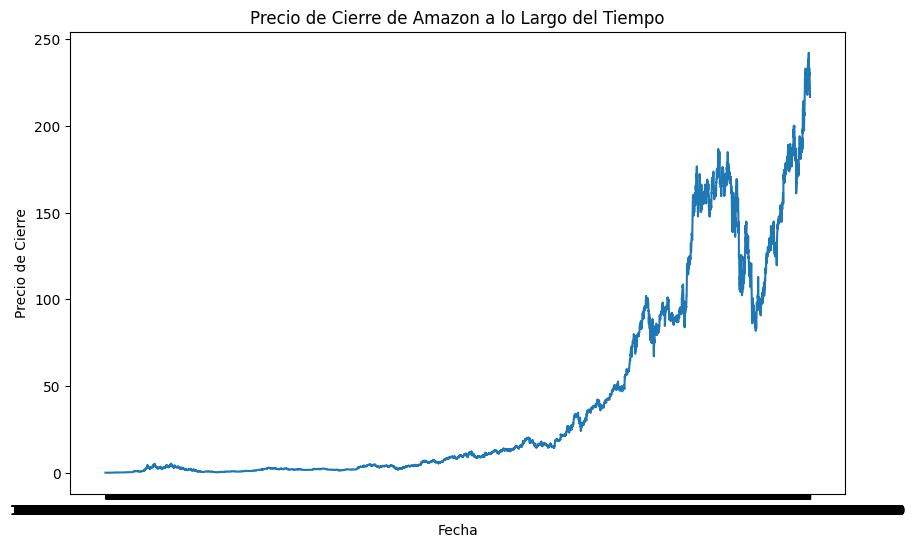

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Precio de Cierre de Amazon a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.show()

División y escalado de datos

In [ ]:
#Datos originales
data = pd.DataFrame(data = df, columns = ["Close"])

#Escalado
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

#Cracion de conjuntos de entrenamiento y prueba

def create_dataset(dataset, look_back): #Se usa un look back de 60 para que hagan pasos en el tiempo
    X, Y = [], []                             #bimestrales
    for i in range(len(dataset) - look_back):
      a = dataset[i:(i + look_back), :]
      X.append(a)
      Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X_train, Y_train = create_dataset(scaled_data, 60)

Creación de modelo

In [ ]:
model = Sequential()
model.add(LSTM(units = 64, input_shape = (X_train.shape[1], 1), return_sequences=True))
model.add(LSTM(units = 64, return_sequences = False))
model.add(Dense(units = 64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units = 1))
model.summary()
model.compile(optimizer = "Adam", loss = "mean_squared_error")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,145 (211.50 KB)

 Trainable params: 54,145 (211.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Entrenar modelo
model.fit(X_train, Y_train, epochs = 25, batch_size = 32, verbose=1)

Epoch 1/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - loss: 0.0076
Epoch 2/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - loss: 0.0028
Epoch 3/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - loss: 0.0018
Epoch 4/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 0.0018
Epoch 5/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 0.0017
Epoch 6/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 0.0017
Epoch 7/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 0.0015
Epoch 8/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - loss: 0.0016
Epoch 9/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 0.0014
Epoch 10/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 0.0014
Epoch 11/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - loss: 0.0013
Epoch 12/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 0.0014
Epoch 13/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - loss: 0.0015
Epoch 14/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 0.0014
Epoch 15/25
217/217 ━━━━━━━━━

In [ ]:
#Comparación con los datos reales
data_real = pd.DataFrame(data=df, columns=["Close"])
data_real_scaled = scaler.fit_transform(data_real)

X_real, _ = create_dataset(np.vstack([scaled_data[-60:], data_real_scaled]), 60)
predictions_scaled = model.predict(X_real)
predictions = scaler.inverse_transform(np.concatenate([predictions_scaled, np.zeros((len(predictions_scaled), 2))], axis=1))[:,0]

real_close = scaler.inverse_transform(data_real_scaled)[:, 0]

219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


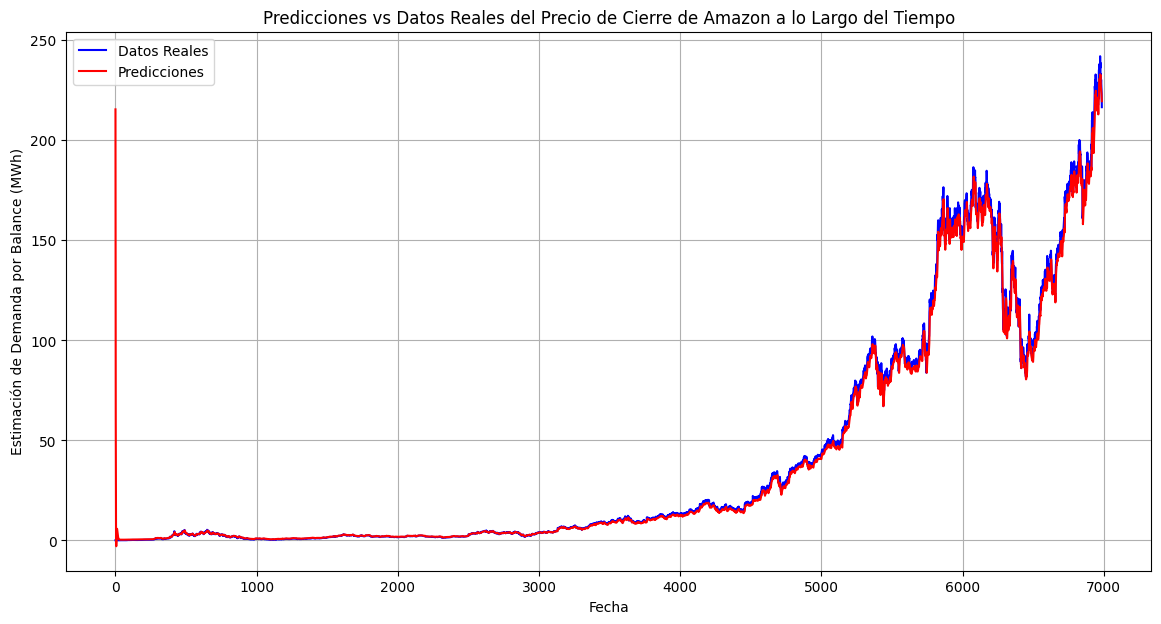

In [ ]:
# Graficar
plt.figure(figsize=(14, 7))
plt.plot(data_real.index, real_close, label='Datos Reales', color='blue')
plt.plot(data_real.index[:len(predictions)], predictions, label='Predicciones', color='red')
plt.title('Predicciones vs Datos Reales del Precio de Cierre de Amazon a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.grid(True)
plt.show()